First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors)

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



2025-01-16 11:07:39.941126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 11:07:39.944672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 11:07:40.236682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 11:07:40.286076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737043660.309981 1954246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737043660.33

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [3]:
PMIdata_path = '../data/count_table/'

## No env model
16s (OTU/phylum/class/order) - no env

ITS (OTU/phylum/class/order) - no env

16s+ITS (OTU/phylum/class/order) - no env (only use this data when calculating H)
bact.ITS.n.class.env

### Data preprocess


In [4]:
bact_ITS_noenv_files = glob.glob(PMIdata_path + 'bact.ITS.n.*.noenv.csv')


In [5]:
bact_ITS_noenv_files

['../data/count_table/bact.ITS.n.otu.noenv.csv',
 '../data/count_table/bact.ITS.n.class.noenv.csv',
 '../data/count_table/bact.ITS.n.order.noenv.csv',
 '../data/count_table/bact.ITS.n.phylum.noenv.csv']

In [6]:
# Read each CSV file into a list of dataframes
bact_ITS_noenv_df_list = [pd.read_csv(file) for file in bact_ITS_noenv_files]
taxlabels = ['OTU', 'class', 'order', 'phylum']

In [7]:
for df in bact_ITS_noenv_df_list:
    print(df.shape)
    


(78, 7415)
(78, 178)
(78, 412)
(78, 52)


In [8]:
# target variable
y = bact_ITS_noenv_df_list[3].iloc[:, 0].values 

# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

print(list(y).count('LONG'))
print(list(y).count('SHORT'))

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']
35
43


In [9]:
bact_ITS_noenv_df_list[3]

,ADH_10_actual,Proteobacteria,Verrucomicrobia,Acidobacteria,Actinobacteria,Firmicutes,Bacteroidetes,Chloroflexi,Rokubacteria,Entotheonellaeota,...,p__Mucoromycota,p__Glomeromycota,p__Monoblepharomycota,p__unclassified_Fungi,p__Zoopagomycota,p__Kickxellomycota,p__Olpidiomycota,p__Aphelidiomycota,p__Blastocladiomycota,p__Basidiobolomycota
0,0.00000,2405.899397,957.553453,1988.986693,2524.409168,92.418396,311.448621,526.359155,123.316076,99.009901,...,86.785175,35.007547,0.209626,127.662251,0.000000,11.739058,0.0,1.886634,4.611773,0.000000
1,1484.14700,3209.276660,757.215776,1727.647573,1840.003679,226.398320,680.881068,465.059244,117.874278,67.904168,...,73.063061,27.939985,0.977899,144.030622,0.000000,7.264396,0.0,4.610098,15.366992,0.000000
2,1989.56009,3829.070365,412.942989,821.982537,1300.667694,389.111454,2416.230098,276.938880,48.073960,41.088855,...,47.127278,1.701346,1.701346,71.966926,0.000000,4.593634,0.0,4.933903,0.510404,0.000000
3,2973.68000,3194.403374,419.280034,848.987596,1688.948376,1069.522046,1868.083981,287.613030,65.055328,42.488288,...,101.508764,6.989128,0.000000,64.122476,0.000000,18.193921,0.0,1.996894,0.000000,3.106279
4,4027.69203,3694.823154,475.772750,833.851140,1209.230357,465.538458,2514.224448,230.271574,60.065548,51.049624,...,493.950429,9.984729,0.587337,96.323270,0.000000,14.096088,0.0,1.468343,1.468343,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,4447.32241,2456.386357,702.629879,1096.355563,2612.831828,1416.120207,209.098033,519.102019,161.669485,29.144499,...,354.041916,2.352438,0.106929,18.712575,0.855432,10.585971,0.0,0.534645,0.000000,0.000000
74,0.00000,2919.908680,1004.519405,1906.070913,954.200252,28.421004,1003.432263,630.853096,87.437295,19.413254,...,34.921758,286.446822,7.956856,438.069136,0.442048,0.884095,0.0,0.000000,0.000000,0.000000
75,1477.74800,4411.744255,735.145847,1127.142509,1262.559538,178.006467,886.381810,434.238431,128.985155,45.718458,...,45.856084,11.620207,0.624742,11.620207,2.623918,0.749691,0.0,0.249897,0.124948,0.000000
76,2554.43400,2821.384741,962.492330,1377.965842,1773.368787,586.137247,543.055840,570.541010,179.740233,65.964410,...,28.655093,12.131353,2.509935,24.262707,1.464129,1.464129,0.0,0.209161,0.000000,0.000000


In [10]:
df_list = []
col_names_4taxa=[]
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)# delete the response column
    df_list.append(data)
    cols_name = df.columns
    col_names_4taxa.append(cols_name)

#### OTU

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

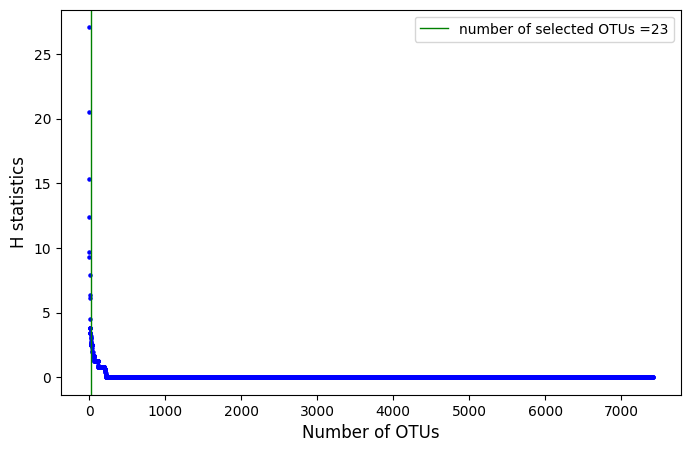

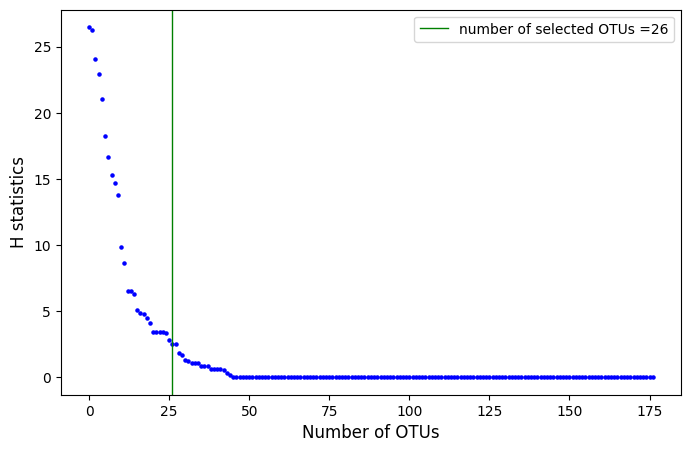

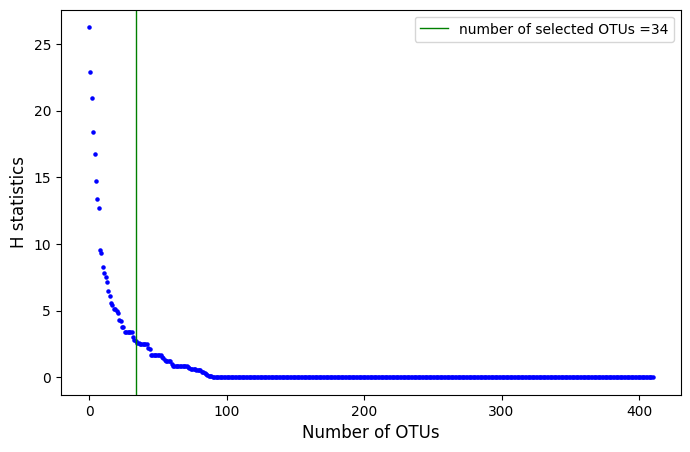

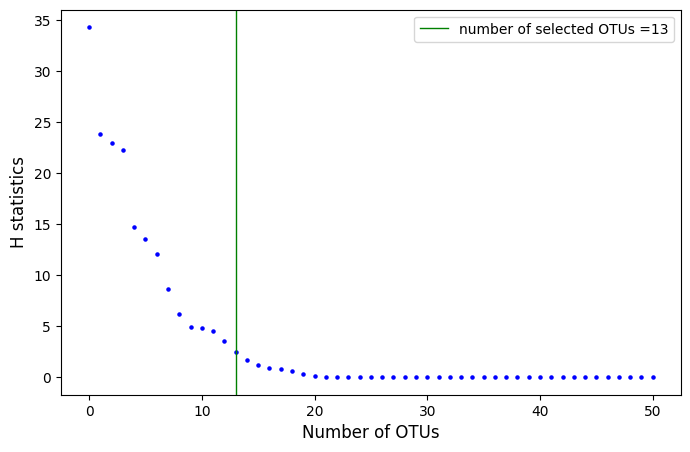

In [11]:
data_4taxa = []
weights_4taxa = []
selectedOTU_index_4tax = []
X_FS_4taxa = []
selectedASVs_4taxa = []
eps_4tax = []
for df in df_list:
    select_result = FS.SelectMicro_fun(df,y)
    data_4taxa.append(select_result['relative_abundance_data'])
    weights_4taxa.append(select_result['H_score'])
    selectedOTU_index_4tax.append(select_result['selected_indices'])
    X_FS_4taxa.append(select_result['selected_data'])
    selectedASVs_4taxa.append(select_result['selected_columnames'])
    eps = len(select_result['selected_indices'])
    eps_4tax.append(eps)

In [12]:
print(eps_4tax)

[23, 26, 34, 13]


In [13]:
for weight in weights_4taxa:
    print(len(weight))

7414
177
411
51


In [14]:
max(weights_4taxa[3])

34.26918116083644

In [15]:
len(selectedOTU_index_4tax)

4

##### 2. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

weights_4taxa,selectedOTU_index_4tax,col_names_4taxa,eps_4tax

In [15]:
#plot the h statistics and cutoff descendingly
#for i in range(len(weights_4taxa)):
    #FS.plotWeightedIndex(weights_4taxa[i],threshold=eps_4tax[i])

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [16]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [17]:
targetLabel=y

In [18]:
data_subset_4taxa = []
X_lasso_4taxa = []
X_lasso_ft_4taxa = []
xind_lasso_4taxa = []
xind_lasso_ft_4taxa = []
for i, data  in enumerate(data_4taxa):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_ft,xind_lasso_ft = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lasso_4taxa.append(X_lasso)
    X_lasso_ft_4taxa.append(X_lasso_ft)
    xind_lasso_4taxa.append(xind_lasso)
    xind_lasso_ft_4taxa.append(xind_lasso_ft)
    data_subset = {"AllFeatures":data, 
                "SelectMicro": X_FS_4taxa[i],
                "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft
              }
    data_subset_4taxa.append(data_subset)

Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05


In [27]:
for i, dataset  in enumerate(data_subset_4taxa):
    data_subset = dataset
    print(taxlabels[i])
    for datatype, subset in data_subset.items():
        print(np.shape(subset))

OTU
(78, 7414)
(78, 23)
(78, 32)
(78, 6)
class
(78, 177)
(78, 26)
(78, 14)
(78, 14)
order
(78, 411)
(78, 34)
(78, 20)
(78, 6)
phylum
(78, 51)
(78, 13)
(78, 6)
(78, 6)


In [20]:
with open('../data/data_subset_4taxa_update.pkl', 'wb') as file:
    pickle.dump(data_subset_4taxa, file)

In [39]:
X_FS_lasso_4taxa = []
selectedOTU_index_FS_lasso_4taxa = []
X_FS_lassoft_4taxa = []
selectedOTU_index_FS_lassoft_4taxa = []

data_FS_lasso_4taxa = []

for i, data  in enumerate(data_4taxa):
    print(taxlabels[i])
        
    X_FS = X_FS_4taxa[i]
    
    X_FS_lasso,xlabel_FS_lasso = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
    X_FS_lasso_4taxa.append(X_FS_lasso)
    selectedOTU_index_FS_lasso_4taxa.append(np.array(selectedOTU_index_4tax[i])[xlabel_FS_lasso])

    X_FS_lasso_ft,xlabel_FS_lasso_ft  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
    X_FS_lassoft_4taxa.append(X_FS_lasso_ft)
    selectedOTU_index_FS_lassoft_4taxa.append(np.array(selectedOTU_index_4tax[i])[xlabel_FS_lasso_ft])
    
    
    data_subset = {"FS_Lasso":X_FS_lasso,
                "FS_Lassofinetune":X_FS_lasso_ft}

    data_FS_lasso_4taxa.append(data_subset)
    
    print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


OTU
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 13)
The shape of the FS_Lasso_finetune selected dataset is  (78, 13)
class
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 11)
The shape of the FS_Lasso_finetune selected dataset is  (78, 11)
order
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 12)
The shape of the FS_Lasso_finetune selected dataset is  (78, 12)
phylum
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 6)
The shape of the FS_Lasso_finetune selected dataset is  (78, 6)


In [28]:
with open('../data/data_FS_lasso_4taxa.pkl', 'wb') as file:
    pickle.dump(data_FS_lasso_4taxa, file)

In [23]:
# AE
data_AE_4taxa = []
for i, data  in enumerate(data_4taxa):
    data_train, data_test, y_train, y_test = RunML_continue.split_and_scale_data(data,targetLabel)
    AE_train, AE_test = RunML_continue.run_AE(data_train,data_test)
    data_AE = pd.concat([AE_train, AE_test], axis=0).to_numpy()
    data_subset = {"Allfeature":data,
                "AE":data_AE}

    data_AE_4taxa.append(data_subset)

latent dimension: 100, activation:tanh, opt:adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
latent dimension: 100, activation:tanh, opt:adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
latent dimension: 100, activation:tanh, opt:adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
latent dimension: 100, activation:tanh, opt:adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [21]:
with open('../data/data_AE_4taxa.pkl', 'wb') as file:
    pickle.dump(data_AE_4taxa, file)

### Fisher_discriminant_ratio

The Fisher Discriminant Ratio is a measure used in statistics and machine learning to evaluate the separability between two or more classes. It is commonly used in Linear Discriminant Analysis (LDA) to reduce dimensionality while preserving as much of the class discriminatory information as possible.

Fisher's Criterion / Fisher's Discriminant Ratio
Fisher's discriminant ratio evaluates how well the classes can be separated based on the ratio of the between-class scatter matrix to the within-class scatter matrix.

In [30]:
for i in range(len(taxlabels)):
    print(f"Analysis of {taxlabels[i]}")
    for datatype, subset in data_subset_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")
    for datatype, subset in data_FS_lasso_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")


Analysis of OTU
f1 of AllFeatures = 0.11001573153998669
f1 of SelectMicro = 0.1824057534954208
f1 of Lasso = 0.24210937729137938
f1 of Lasso_finetune = 0.36988708234793455
f1 of FS_Lasso = 0.24188310358490397
f1 of FS_Lassofinetune = 0.24188310358490397
Analysis of class
f1 of AllFeatures = 0.2297476496121627
f1 of SelectMicro = 0.27018731598328394
f1 of Lasso = 0.33434739542998504
f1 of Lasso_finetune = 0.33434739542998504
f1 of FS_Lasso = 0.34073125238636975
f1 of FS_Lassofinetune = 0.34073125238636975
Analysis of order
f1 of AllFeatures = 0.22390816584976964
f1 of SelectMicro = 0.28878888861154195
f1 of Lasso = 0.35736325231498683
f1 of Lasso_finetune = 0.4142877545767314
f1 of FS_Lasso = 0.3725220018616517
f1 of FS_Lassofinetune = 0.3725220018616517
Analysis of phylum
f1 of AllFeatures = 0.16186376884683504
f1 of SelectMicro = 0.225994270936303
f1 of Lasso = 0.3071114522305581
f1 of Lasso_finetune = 0.3071114522305581
f1 of FS_Lasso = 0.3071114522305581
f1 of FS_Lassofinetune = 0.3

In [22]:
for i in range(len(taxlabels)):
    print(f"Analysis of {taxlabels[i]}")
    for datatype, subset in data_AE_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")

Analysis of OTU
f1 of Allfeature = 0.11001573153998669
f1 of AE = 0.010849294252693653
Analysis of class
f1 of Allfeature = 0.2297476496121627
f1 of AE = 0.010389471426606178
Analysis of order
f1 of Allfeature = 0.22390816584976964
f1 of AE = 0.008239131420850754
Analysis of phylum
f1 of Allfeature = 0.16186376884683504
f1 of AE = 0.011431599967181683


### compare the first 15 index by their present ratio

Index(['ITS00002', 'ITS00001', 'ITS00006', 'Otu00009', 'ITS00008', 'Otu00008',
       'Otu00007', 'ITS00013', 'ITS00014', 'ITS00012', 'Otu00003', 'Otu00014',
       'Otu00039', 'ITS00011', 'ITS00043'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   ITS00002      0.828571      0.279070
1   ITS00001      0.800000      0.279070
2   ITS00006      0.228571      0.627907
3   Otu00009      0.028571      0.348837
4   ITS00008      0.400000      0.116279
5   Otu00008      0.200000      0.000000
6   Otu00007      0.057143      0.302326
7   ITS00013      0.200000      0.023256
8   ITS00014      0.200000      0.023256
9   ITS00012      0.114286      0.302326
10  Otu00003      0.085714      0.000000
11  Otu00014      0.085714      0.000000
12  Otu00039      0.085714      0.000000
13  ITS00011      0.085714      0.000000
14  ITS00043      0.085714      0.000000


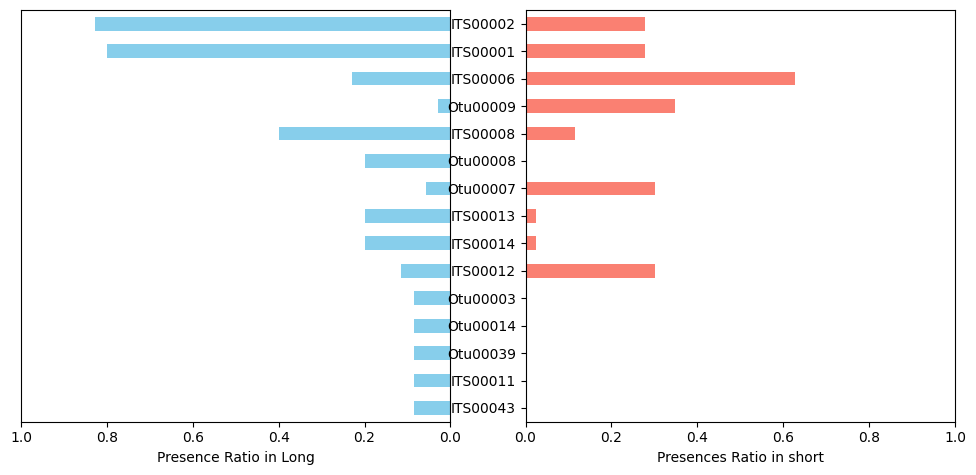

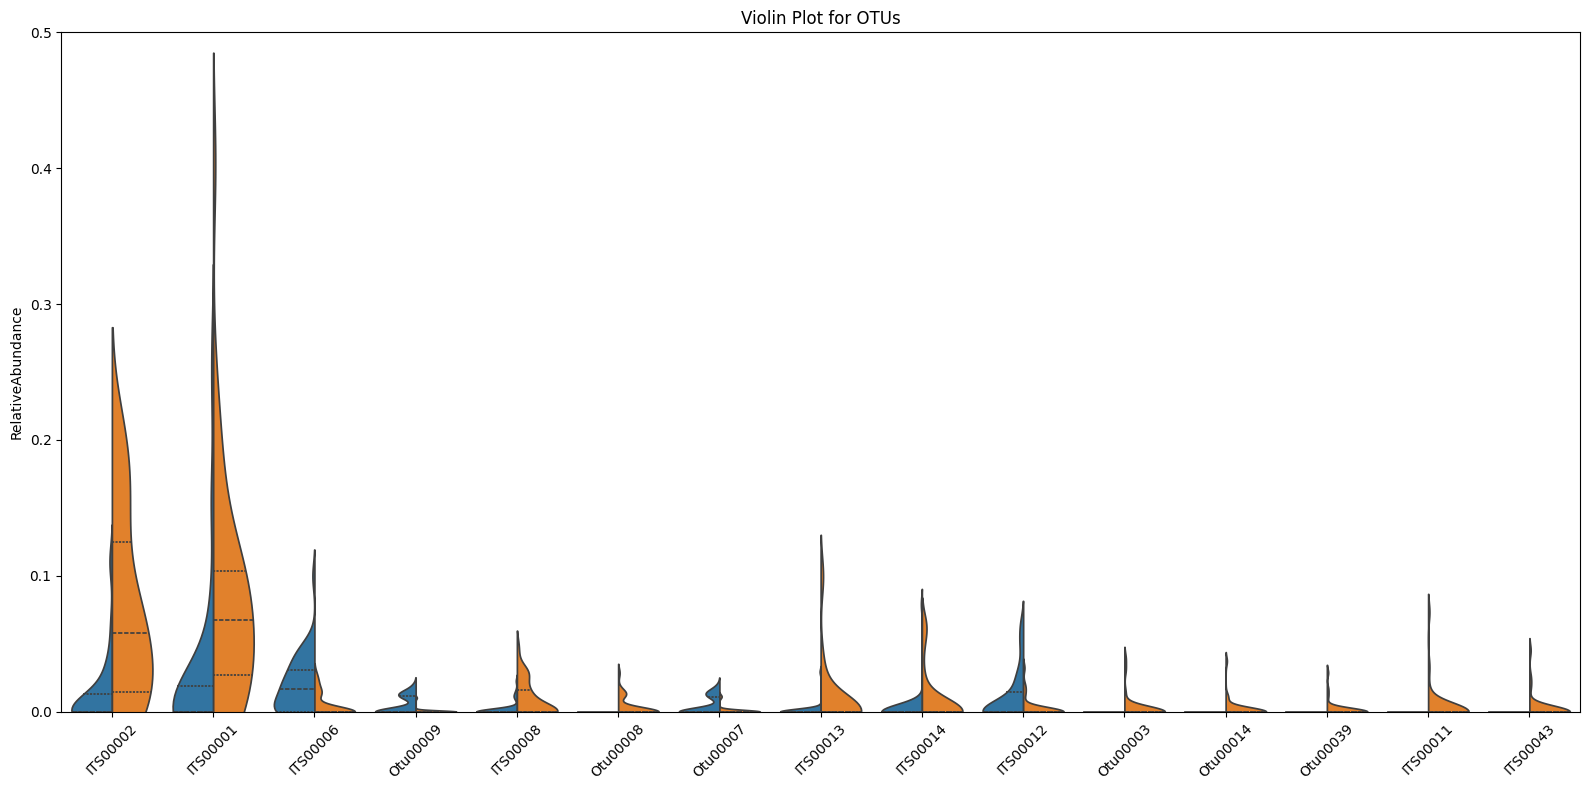

Index(['c__Dothideomycetes', 'c__Saccharomycetes', 'c__Agaricomycetes',
       'k__Fungi_unclassified', 'Clostridia', 'Bacilli', 'Subgroup_6',
       'Deltaproteobacteria', 'c__unclassified_Fungi',
       'Blastocatellia_(Subgroup_4)', 'c__Rozellomycotina_cls_Incertae_sedis',
       'Verrucomicrobiae', 'Phycisphaerae', 'c__unclassified_Rozellomycota',
       'Actinobacteria'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                      OTU  presence_pos  presence_neg
0                      c__Dothideomycetes      0.142857      0.720930
1                      c__Saccharomycetes      0.885714      0.488372
2                       c__Agaricomycetes      0.257143      0.790698
3                   k__Fungi_unclassified      0.685714      0.953488
4                              Clostridia      0.600000      0.139535
5                                 Bacilli      0.685714      0.279070
6                              Subg

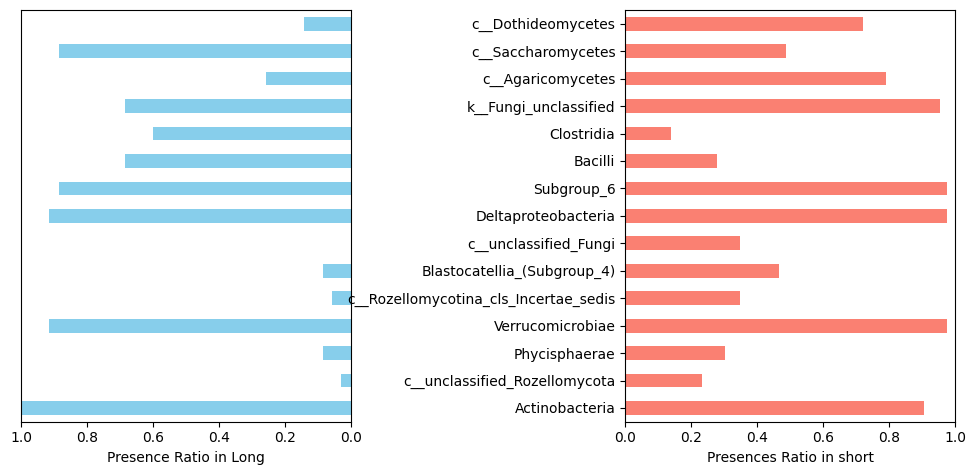

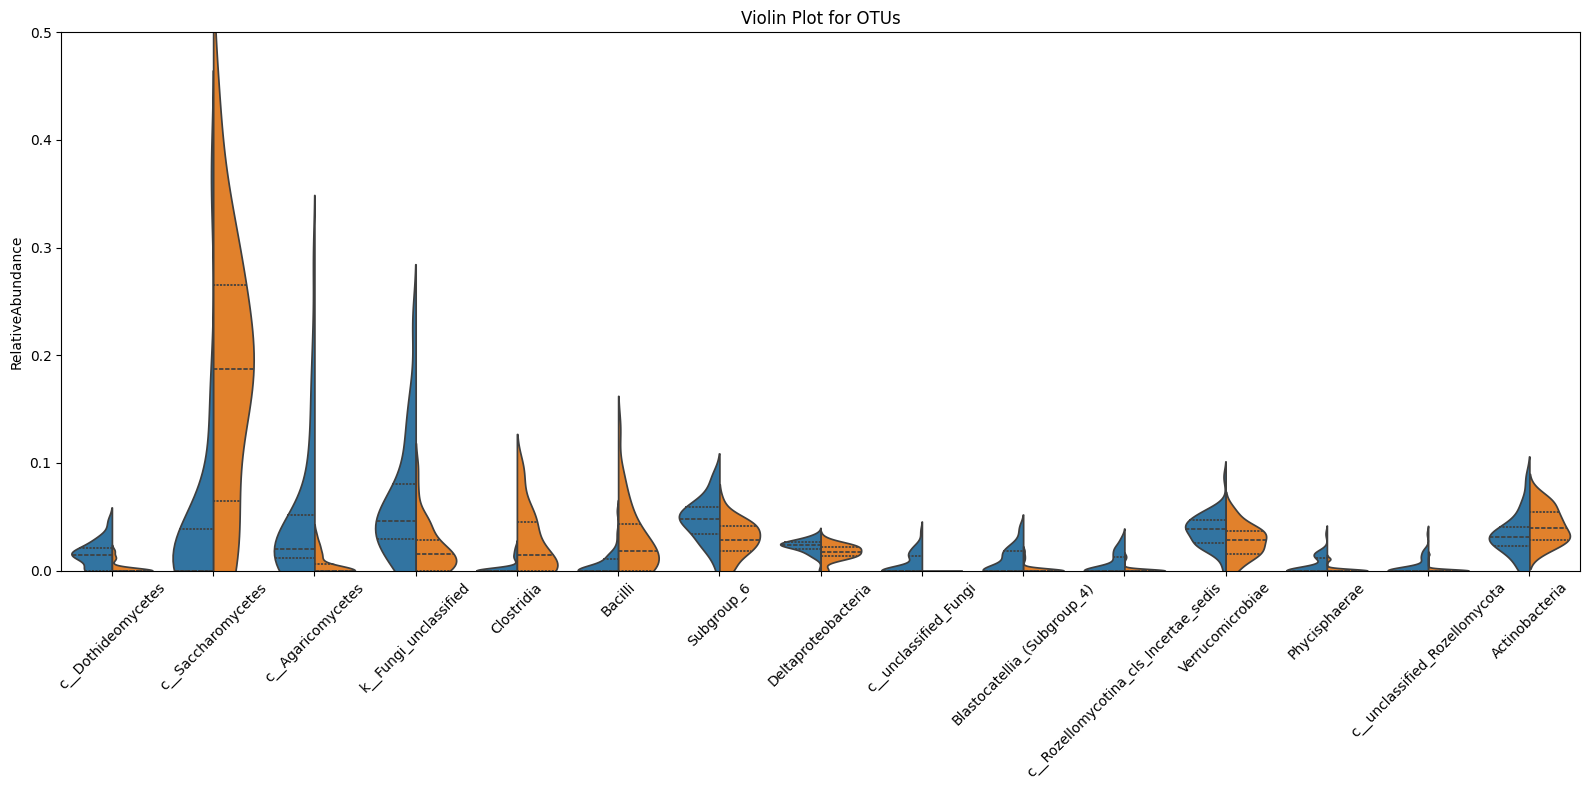

Index(['o__Saccharomycetales', 'k__Fungi_unclassified', 'Clostridiales',
       'Pedosphaerales', 'Subgroup_6_or', 'o__unclassified_Fungi',
       'Chitinophagales', 'o__Pleosporales', 'Bacillales',
       'Bacilli_unclassified', 'Corynebacteriales', 'Tepidisphaerales',
       'o__Agaricales', 'Pyrinomonadales', 'o__unclassified_Rozellomycota'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                              OTU  presence_pos  presence_neg
0            o__Saccharomycetales      0.885714      0.488372
1           k__Fungi_unclassified      0.685714      0.953488
2                   Clostridiales      0.600000      0.139535
3                  Pedosphaerales      0.000000      0.418605
4                   Subgroup_6_or      0.885714      0.976744
5           o__unclassified_Fungi      0.000000      0.348837
6                 Chitinophagales      0.314286      0.744186
7                 o__Pleosporales      0.085714      0.441860

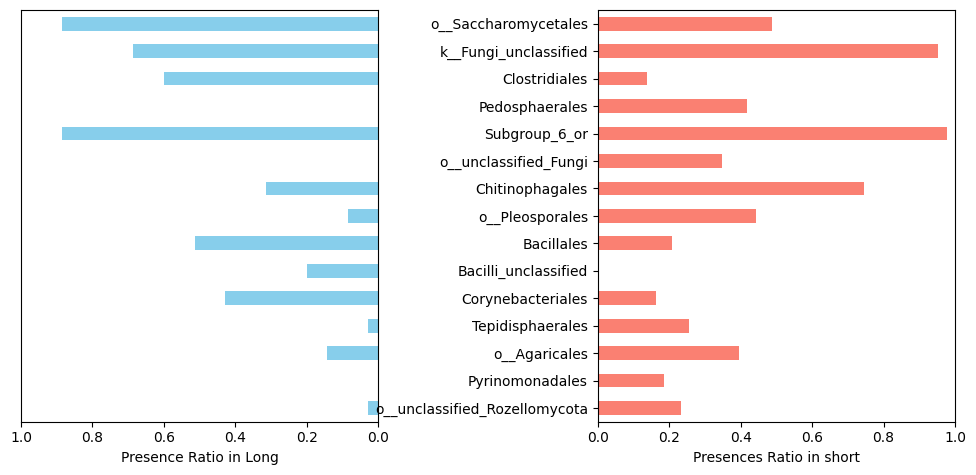

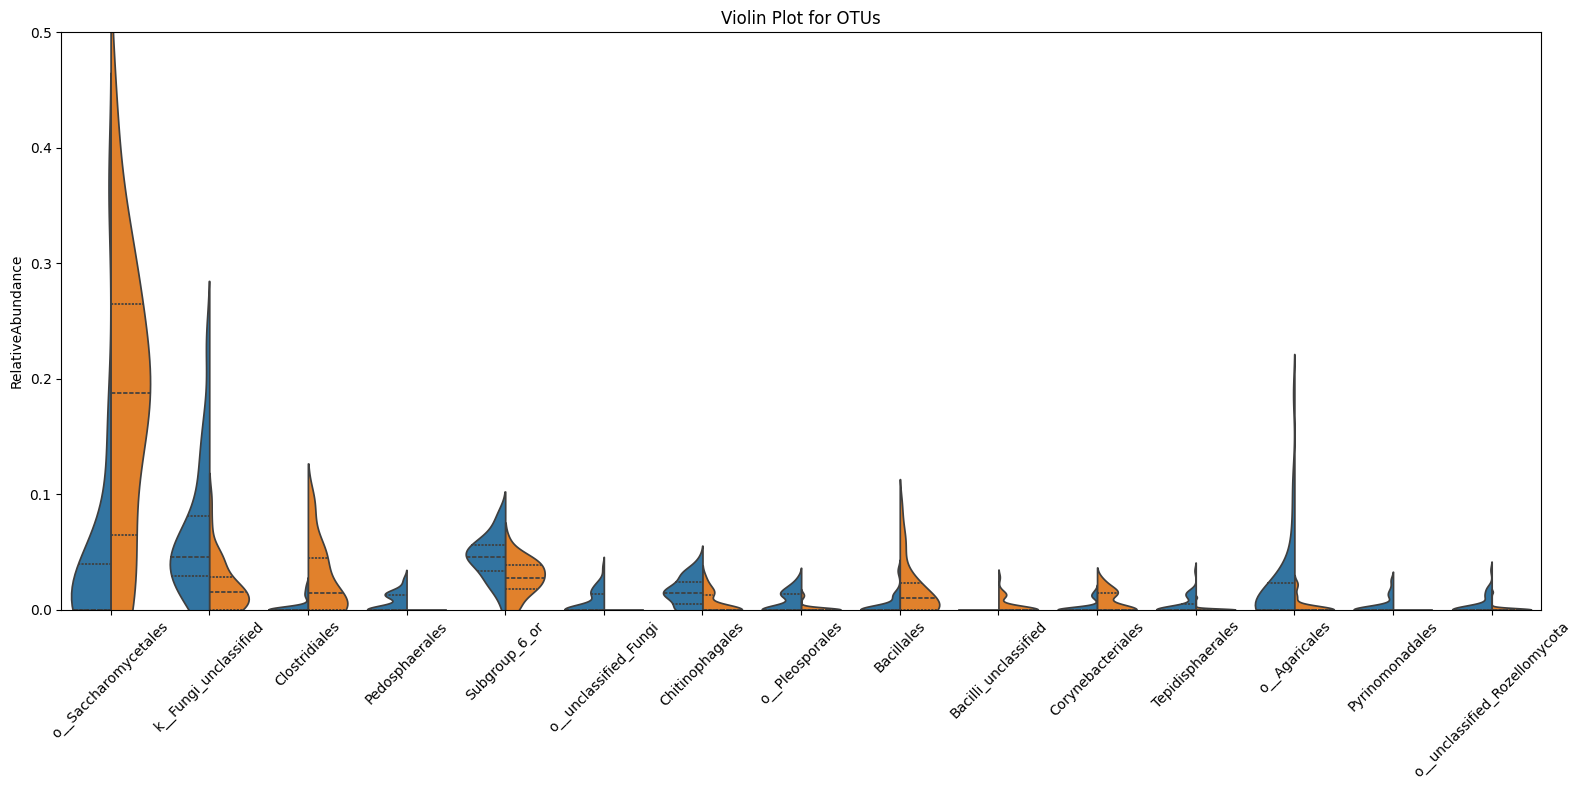

Index(['Firmicutes', 'p__Rozellomycota', 'k__Fungi_unclassified',
       'Acidobacteria', 'p__unclassified_Fungi', 'p__Chytridiomycota',
       'p__Ascomycota', 'Verrucomicrobia', 'p__Glomeromycota',
       'Gemmatimonadetes', 'Planctomycetes', 'Bacteroidetes',
       'p__Mortierellomycota'],
      dtype='object')
(78, 13)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                      OTU  presence_pos  presence_neg
0              Firmicutes      0.942857      0.418605
1        p__Rozellomycota      0.171429      0.767442
2   k__Fungi_unclassified      0.685714      0.953488
3           Acidobacteria      0.971429      1.000000
4   p__unclassified_Fungi      0.000000      0.348837
5      p__Chytridiomycota      0.000000      0.325581
6           p__Ascomycota      1.000000      1.000000
7         Verrucomicrobia      0.914286      0.976744
8        p__Glomeromycota      0.000000      0.162791
9        Gemmatimonadetes      0.057143      0.232558
10         Planct

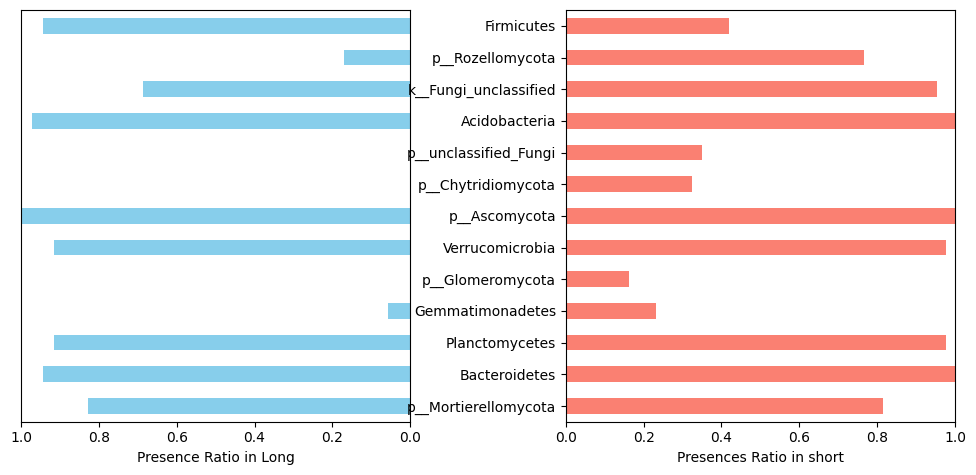

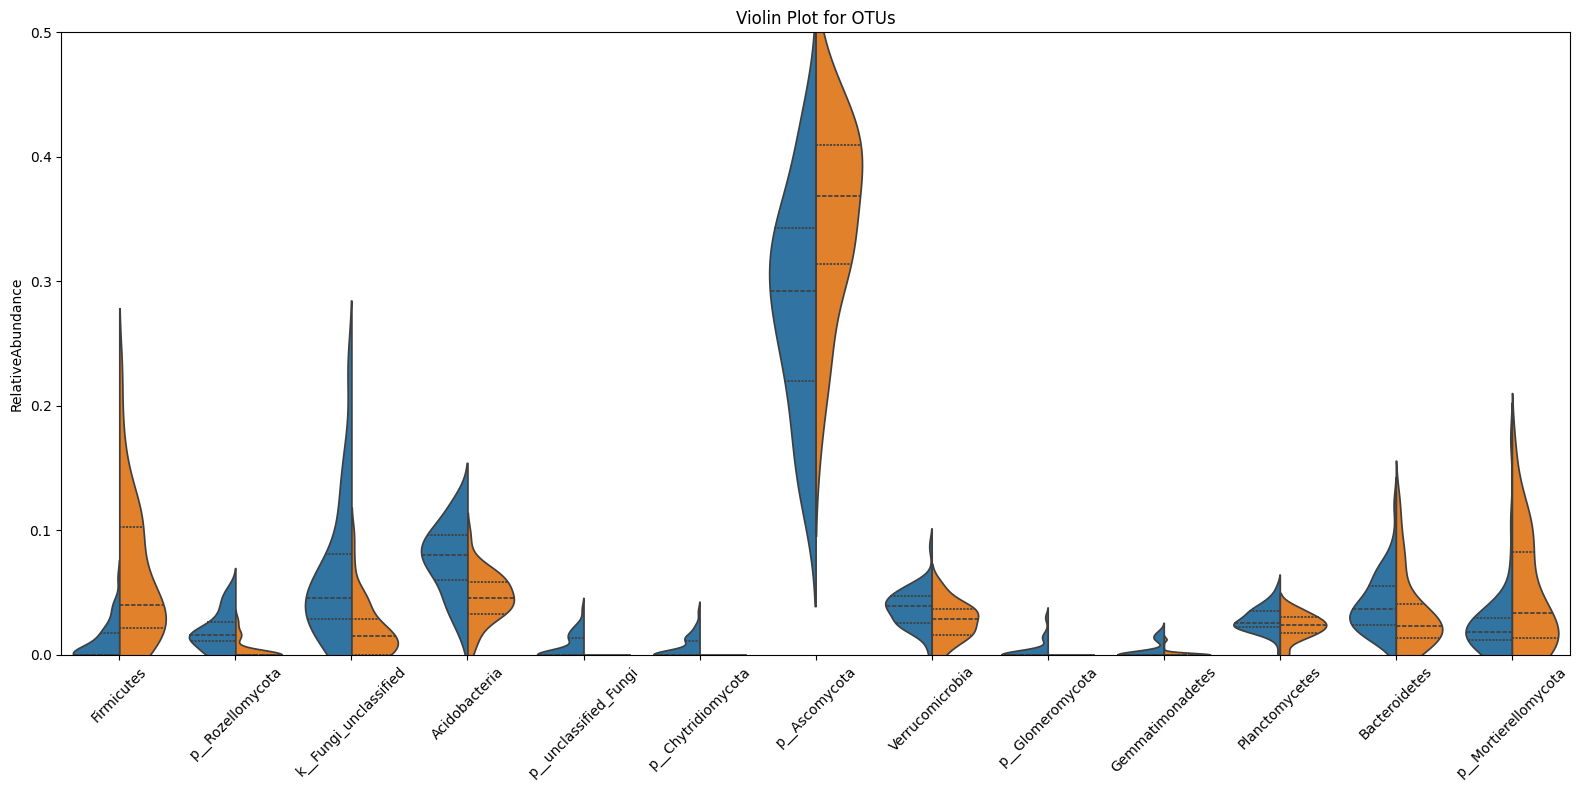

In [23]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15

for i, data_FS in enumerate(X_FS_4taxa):
    selectedASVs_15=selectedASVs_4taxa[i][:entries]
    print(selectedASVs_15)
    X_FS_15=data_FS[:,:entries]
    print(X_FS_15.shape)
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5)

Fine tuned Lasso selected Index(['Otu00007', 'Otu00008', 'ITS00001', 'ITS00005', 'ITS00007', 'ITS00024'], dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
        OTU  presence_pos  presence_neg
0  Otu00007      0.200000      0.000000
1  Otu00008      0.028571      0.348837
2  ITS00001      0.828571      0.279070
3  ITS00005      0.228571      0.627907
4  ITS00007      0.400000      0.116279
5  ITS00024      0.114286      0.023256


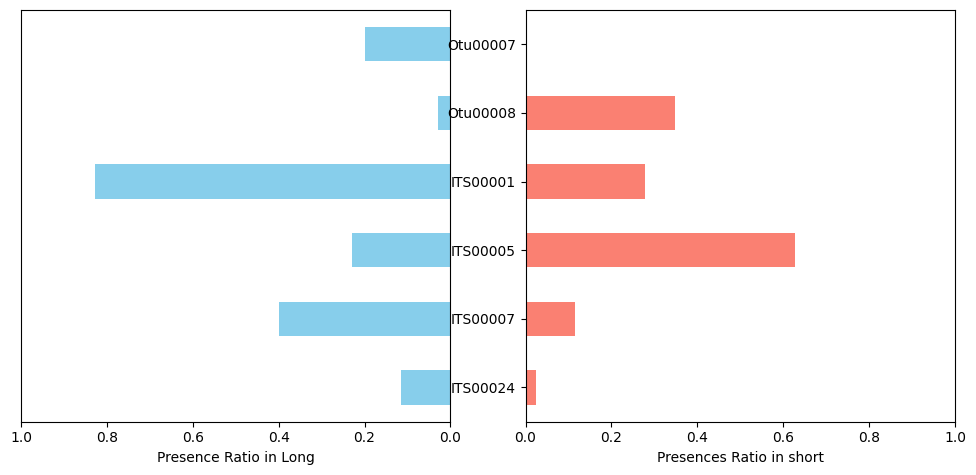

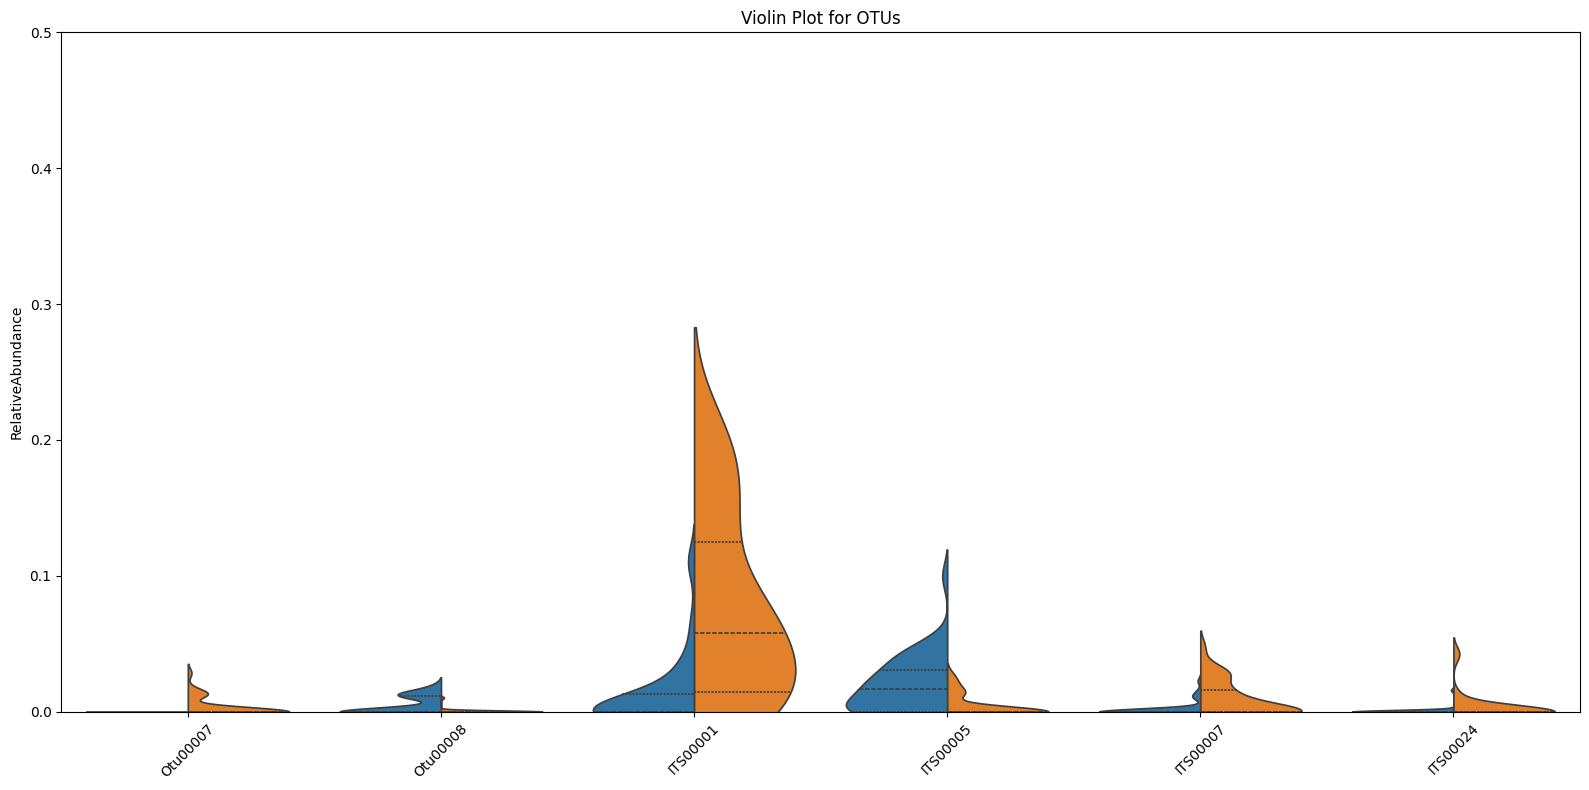

Fine tuned Lasso selected Index(['Gammaproteobacteria', 'Deltaproteobacteria', 'Lineage_IIc',
       'c__Sordariomycetes', 'c__Tremellomycetes', 'c__Eurotiomycetes',
       'c__Mortierellomycetes', 'c__Atractiellomycetes',
       'c__Microbotryomycetes', 'p__Rozellomycota_unclassified',
       'c__unclassified_Rozellomycota', 'c__Mucoromycetes',
       'c__Sanchytriomycetes', 'c__unclassified_Fungi'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                              OTU  presence_pos  presence_neg
0             Gammaproteobacteria      0.600000      0.139535
1             Deltaproteobacteria      0.685714      0.279070
2                     Lineage_IIc      0.885714      0.488372
3              c__Sordariomycetes      0.771429      0.604651
4              c__Tremellomycetes      0.485714      0.651163
5               c__Eurotiomycetes      0.771429      0.813953
6           c__Mortierellomycetes      0.685714      0.953488
7           c

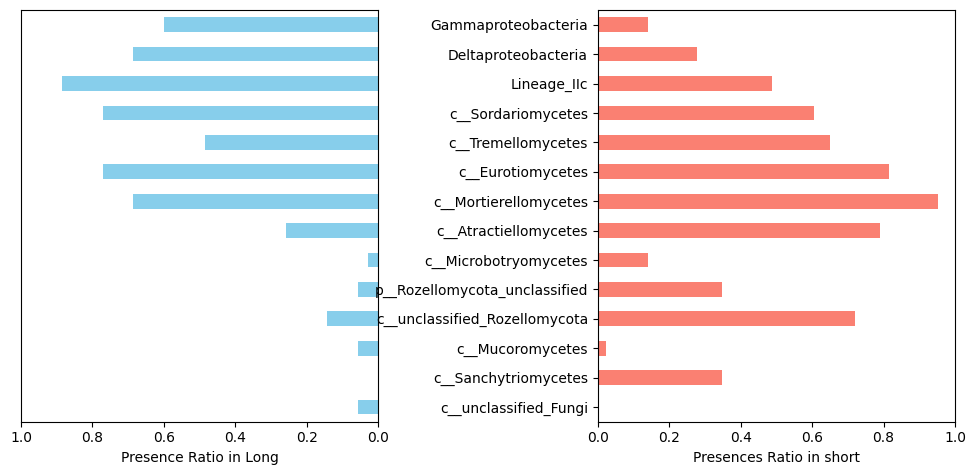

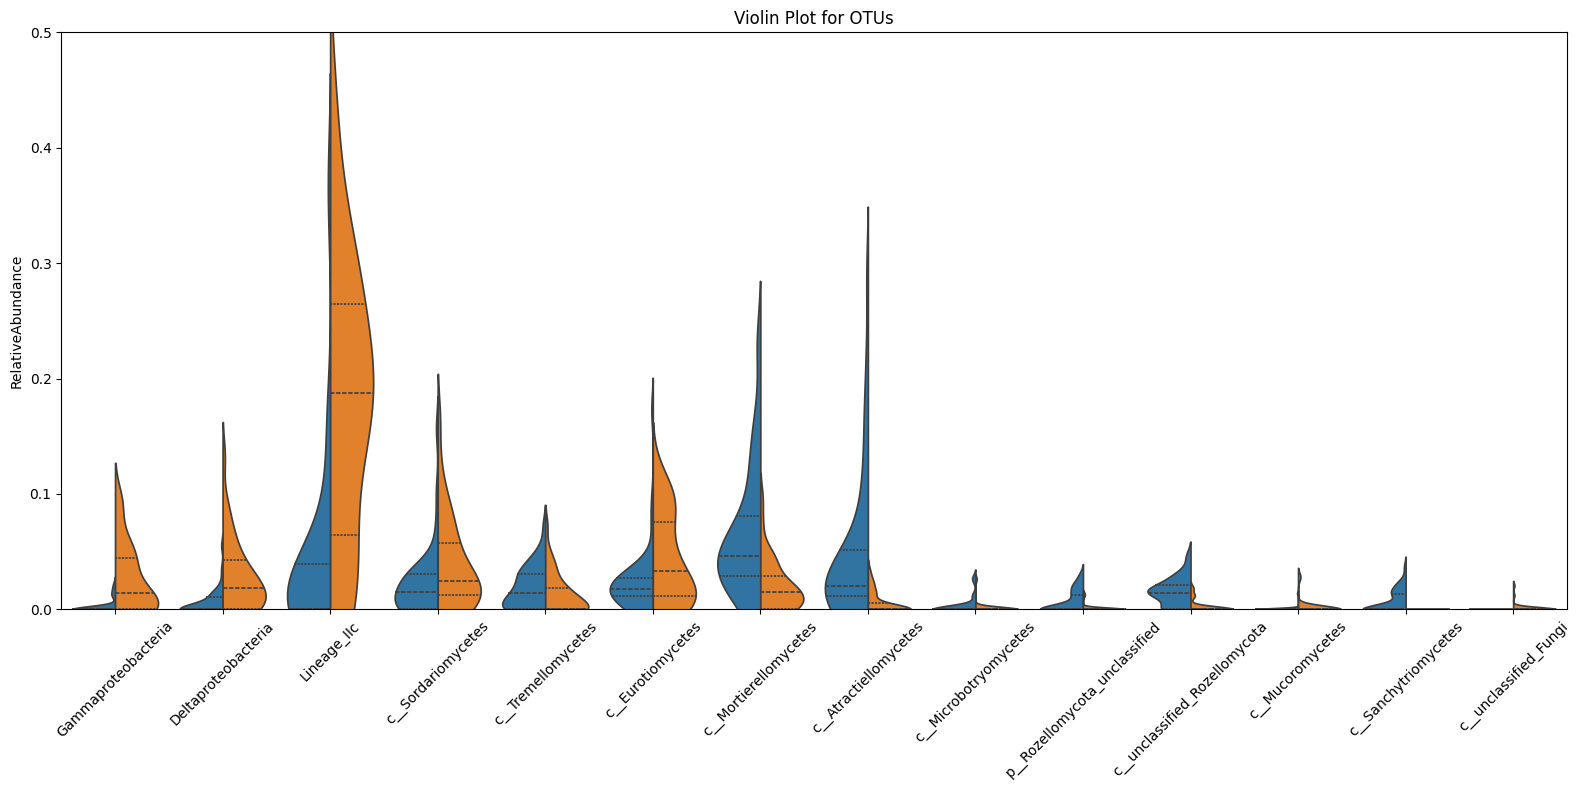

Fine tuned Lasso selected Index(['Pseudomonadales', 'Micromonosporales', 'Candidatus_Magasanikbacteria',
       'o__Eurotiales', 'o__Leucosporidiales', 'o__unclassified_Fungi'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                            OTU  presence_pos  presence_neg
0               Pseudomonadales      0.600000      0.139535
1             Micromonosporales      0.000000      0.418605
2  Candidatus_Magasanikbacteria      0.885714      0.488372
3                 o__Eurotiales      0.771429      0.813953
4           o__Leucosporidiales      0.085714      0.441860
5         o__unclassified_Fungi      0.057143      0.000000


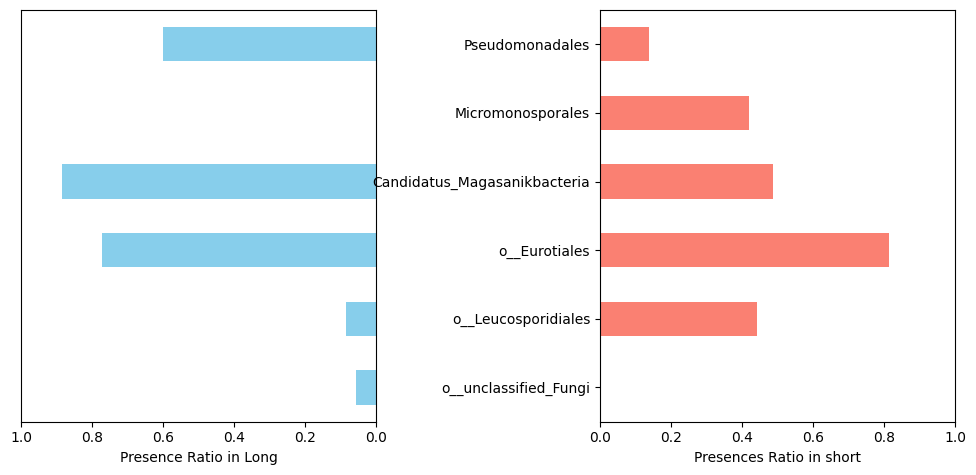

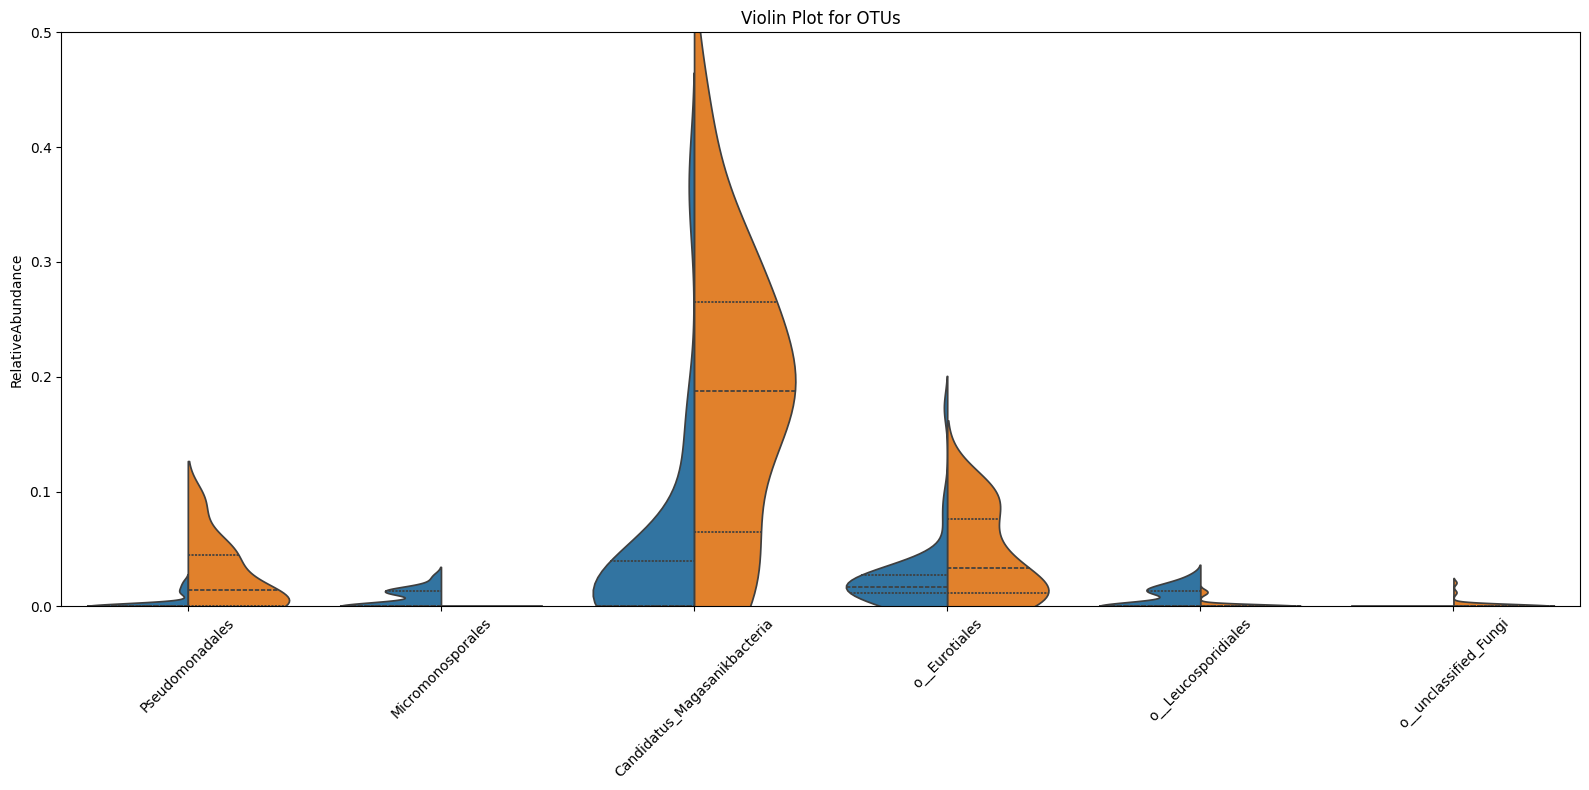

Fine tuned Lasso selected Index(['Verrucomicrobia', 'Actinobacteria', 'p__Basidiomycota',
       'k__Fungi_unclassified', 'p__Rozellomycota', 'p__Monoblepharomycota'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0        Verrucomicrobia      0.971429      1.000000
1         Actinobacteria      0.942857      0.418605
2       p__Basidiomycota      0.828571      0.813953
3  k__Fungi_unclassified      0.171429      0.767442
4       p__Rozellomycota      0.000000      0.325581
5  p__Monoblepharomycota      0.000000      0.348837


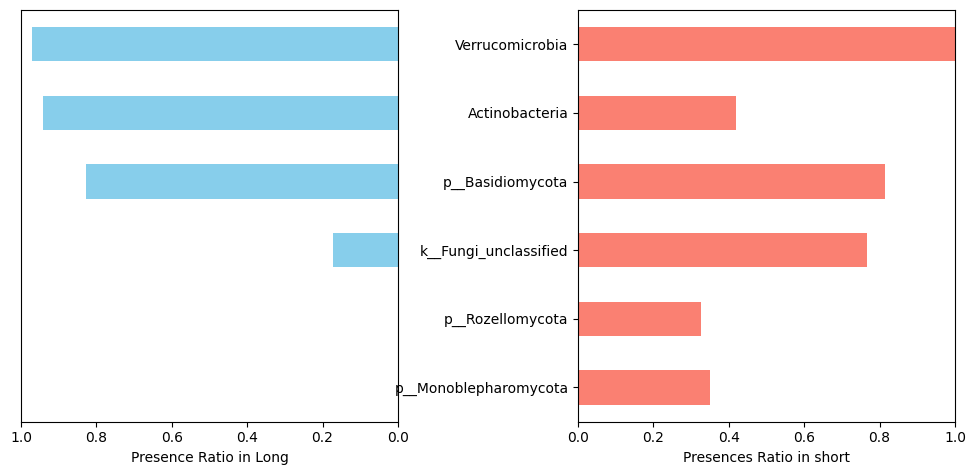

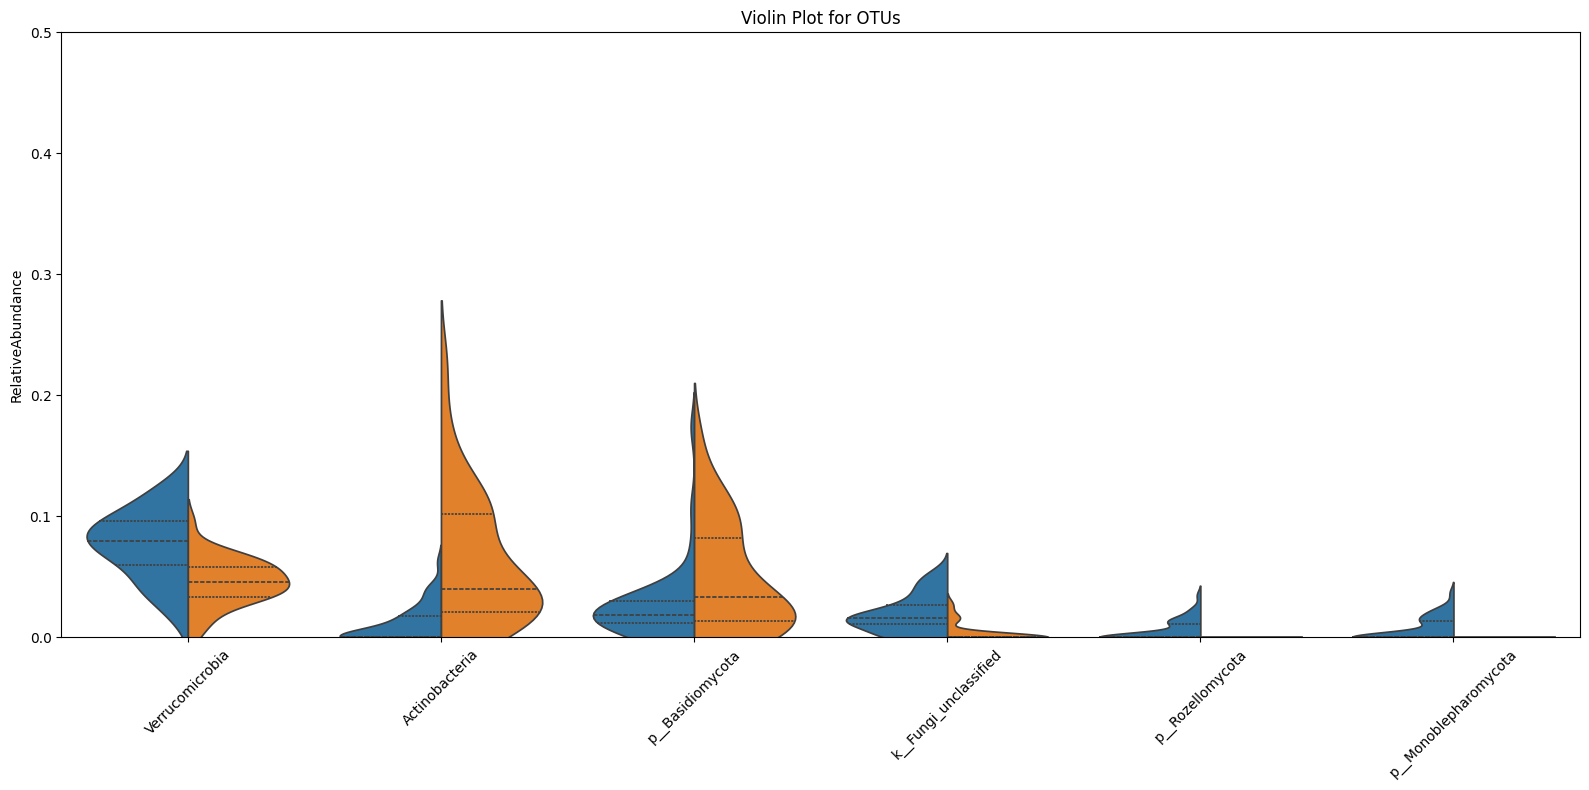

In [24]:
for i, data_FS in enumerate(X_lasso_ft_4taxa):
    selectedASVs_15=col_names_4taxa[i][xind_lasso_ft_4taxa[i]]
    print(f"Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,xind_lasso_ft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5) 
    

FS_Fine tuned Lasso selected Index(['ITS00001', 'ITS00005', 'Otu00008', 'ITS00007', 'Otu00007', 'Otu00006',
       'ITS00012', 'Otu00018', 'ITS00021', 'ITS00027', 'ITS00026', 'ITS00003',
       'Otu00014'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   ITS00001      0.828571      0.279070
1   ITS00005      0.228571      0.627907
2   Otu00008      0.028571      0.348837
3   ITS00007      0.400000      0.116279
4   Otu00007      0.200000      0.000000
5   Otu00006      0.057143      0.302326
6   ITS00012      0.200000      0.023256
7   Otu00018      0.000000      0.093023
8   ITS00021      0.000000      0.093023
9   ITS00027      0.000000      0.093023
10  ITS00026      0.171429      0.046512
11  ITS00003      0.657143      0.511628
12  Otu00014      0.114286      0.023256


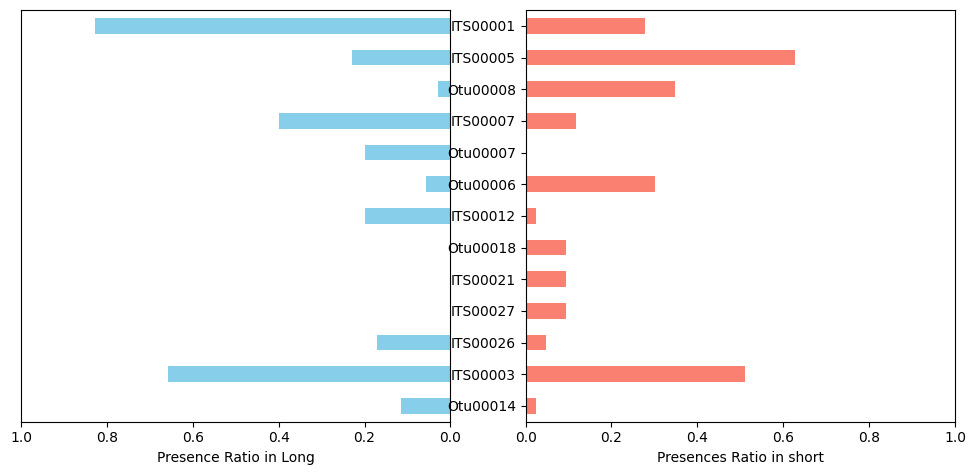

FS_Fine tuned Lasso selected Index(['c__unclassified_Rozellomycota', 'Lineage_IIc', 'c__Atractiellomycetes',
       'c__Mortierellomycetes', 'Gammaproteobacteria', 'Deltaproteobacteria',
       'c__Sanchytriomycetes', 'p__Rozellomycota_unclassified',
       'c__Sordariomycetes', 'c__Eurotiomycetes', 'c__Microbotryomycetes'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                              OTU  presence_pos  presence_neg
0   c__unclassified_Rozellomycota      0.142857      0.720930
1                     Lineage_IIc      0.885714      0.488372
2           c__Atractiellomycetes      0.257143      0.790698
3           c__Mortierellomycetes      0.685714      0.953488
4             Gammaproteobacteria      0.600000      0.139535
5             Deltaproteobacteria      0.685714      0.279070
6            c__Sanchytriomycetes      0.000000      0.348837
7   p__Rozellomycota_unclassified      0.057143      0.348837
8              c__Sordariomyc

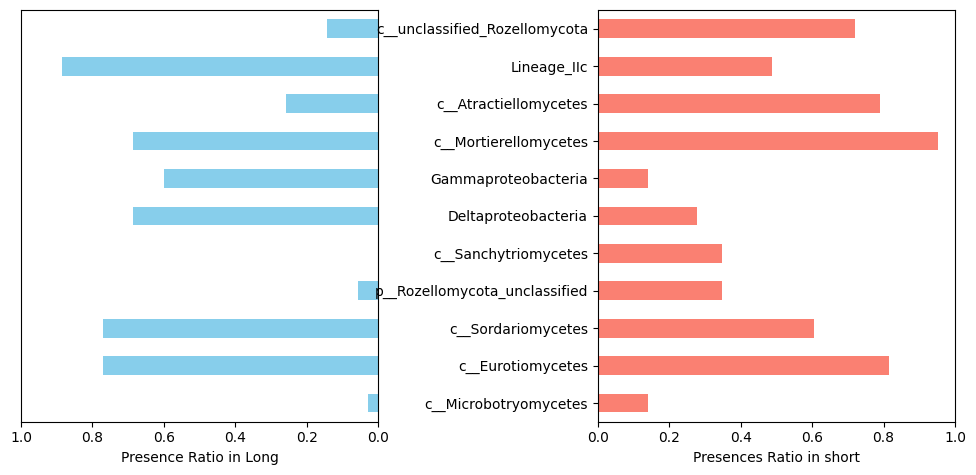

FS_Fine tuned Lasso selected Index(['Candidatus_Magasanikbacteria', 'Pseudomonadales', 'Micromonosporales',
       'Chthoniobacterales', 'o__Sanchytriales', 'o__Leucosporidiales',
       'Corynebacteriales', 'Subgroup_6_or', 'o__Microascales',
       'o__Eurotiales', 'o__Pleosporales', 'o__Onygenales'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                             OTU  presence_pos  presence_neg
0   Candidatus_Magasanikbacteria      0.885714      0.488372
1                Pseudomonadales      0.600000      0.139535
2              Micromonosporales      0.000000      0.418605
3             Chthoniobacterales      0.885714      0.976744
4               o__Sanchytriales      0.000000      0.348837
5            o__Leucosporidiales      0.085714      0.441860
6              Corynebacteriales      0.514286      0.209302
7                  Subgroup_6_or      0.200000      0.000000
8                o__Microascales      0.742857      0.581395

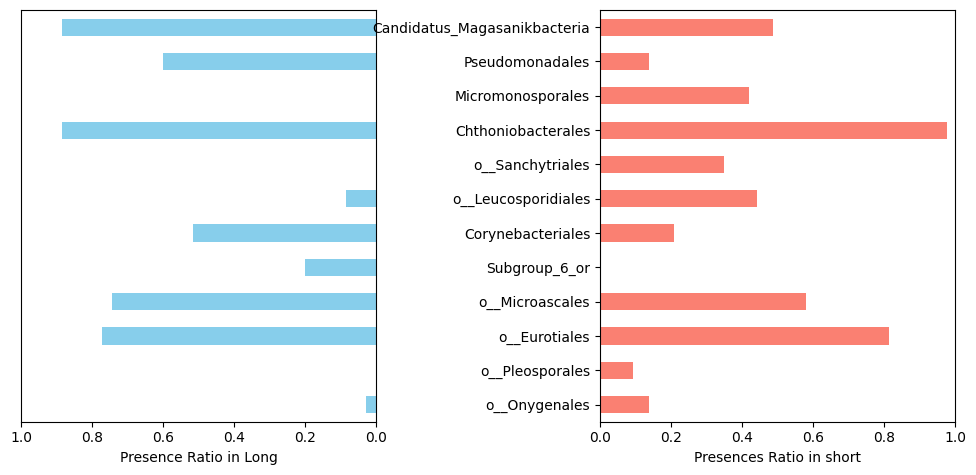

FS_Fine tuned Lasso selected Index(['Actinobacteria', 'k__Fungi_unclassified', 'Verrucomicrobia',
       'p__Monoblepharomycota', 'p__Rozellomycota', 'p__Basidiomycota'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0         Actinobacteria      0.942857      0.418605
1  k__Fungi_unclassified      0.171429      0.767442
2        Verrucomicrobia      0.971429      1.000000
3  p__Monoblepharomycota      0.000000      0.348837
4       p__Rozellomycota      0.000000      0.325581
5       p__Basidiomycota      0.828571      0.813953


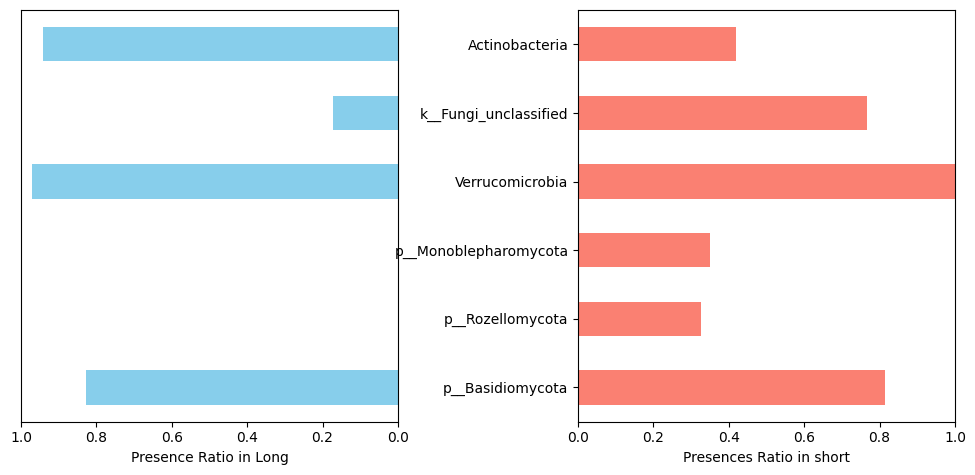

In [41]:
for i, data_FS in enumerate(X_FS_lassoft_4taxa):
    selectedASVs_15=col_names_4taxa[i][selectedOTU_index_FS_lassoft_4taxa[i]]
    print(f"FS_Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,selectedOTU_index_FS_lassoft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
  

In [36]:
X_FS_lassoft_4taxa

[]